# 📁 Projet final – Data Crafting & Data Mining

Ce projet vous permettra de mettre en œuvre tout le cycle de traitement de données :
- Qualité et structuration (Data Crafting)
- Exploration, préparation et modélisation (Data Mining)

**Domaine :** Gestion des ressources humaines (1200 employés)

**Choix de modélisation :** 2 modélisations possibles à la partie 5. Faites votre choix et poursuivez le projet
- Classification : Construire un modèle prédictif du type de contrat et Évaluer la précision sur les nouveaux employés
- Clustering : Identifier naturellement des profils d’employés et Interpréter les groupes pour recommandations RH

**Fichier de données :** `dataset_rh.csv`

📅 Délai de rendu : 1 semaine après la fin du module.

##  Partie 1 – Chargement & exploration initiale

In [67]:
# Importations
import pandas as pd
import numpy as np
import great_expectations as gx
import matplotlib.pyplot as plt
import seaborn as sns
import pydantic as pdct
import sklearn as sk
import mlxtend as mlx

# Importations pour la partie Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
)

In [68]:

# Charger le dataset
df = pd.read_csv("dataset_rh.csv")
df_raw = df.copy()


In [69]:

# TODO : Afficher les 5 premières lignes et les dimensions du dataset
# ...
print("Dimensions:", df.shape)
display(df.head(5))

Dimensions: (1200, 11)


,EmployeID,Nom,Prenom,Age,Sexe,Departement,Poste,Salaire,NiveauEtude,TypeContrat,DateEmbauche
0,EMP00000,Dijoux,Zacharie,36,F,Marketing,Chargé de com,21649.44,Bac+3,Stage,2017-03-17
1,EMP00001,Philippe,Théophile,64,H,Marketing,Chargé de com,22127.03,Bac+3,CDI,NaN
2,EMP00002,Blondel,Catherine,53,H,Production,Comptable,26105.59,Bac+3,Alternance,2023-05-02
3,EMP00003,Berthelot,Maryse,47,H,Marketing,Chef de projet,29066.15,Master,CDD,2016-03-24
4,EMP00004,Clément,Christelle,25,F,Informatique,Développeur,34440.50,Bac+2,CDI,2016-09-04


##  Partie 2 – nettoyage, alignement, validation puis pipeline

In [70]:
# TODO :
# - Identifier les colonnes avec des valeurs manquantes ou corrompues
def identify_missing_values(df):
    missing = df.isna().sum().sort_values(ascending=False)
    display(missing[missing > 0])
    return df

identify_missing_values(df)


NiveauEtude     120
TypeContrat     108
Sexe             62
DateEmbauche     55
dtype: int64

,EmployeID,Nom,Prenom,Age,Sexe,Departement,Poste,Salaire,NiveauEtude,TypeContrat,DateEmbauche
0,EMP00000,Dijoux,Zacharie,36,F,Marketing,Chargé de com,21649.44,Bac+3,Stage,2017-03-17
1,EMP00001,Philippe,Théophile,64,H,Marketing,Chargé de com,22127.03,Bac+3,CDI,NaN
2,EMP00002,Blondel,Catherine,53,H,Production,Comptable,26105.59,Bac+3,Alternance,2023-05-02
3,EMP00003,Berthelot,Maryse,47,H,Marketing,Chef de projet,29066.15,Master,CDD,2016-03-24
4,EMP00004,Clément,Christelle,25,F,Informatique,Développeur,34440.50,Bac+2,CDI,2016-09-04
...,...,...,...,...,...,...,...,...,...,...,...
1195,EMP01195,Boyer,Maurice,60,H,Marketing,RH,40929.50,Bac,Stage,2022-10-19
1196,EMP01196,Roche,Capucine,-1,H,Finance,Comptable,23659.68,Bac,CDD,2021-08-08
1197,EMP01197,Tanguy,Lucy,-1,H,Logistique,Technicien,24775.49,Bac+3,NaN,2020-06-23
1198,EMP01198,Labbé,Victor,54,F,Informatique,Technicien,29751.96,Bac,CDI,2018-07-25


In [71]:

# - Corriger les âges aberrants, les salaires négatifs
def clean_age_salary(df):
    df.loc[(df["Age"] < 18) | (df["Age"] > 64), "Age"] = np.nan
    df.loc[df["Salaire"] <= 0, "Salaire"] = np.nan 
    return df

clean_age_salary(df)


,EmployeID,Nom,Prenom,Age,Sexe,Departement,Poste,Salaire,NiveauEtude,TypeContrat,DateEmbauche
0,EMP00000,Dijoux,Zacharie,36.0,F,Marketing,Chargé de com,21649.44,Bac+3,Stage,2017-03-17
1,EMP00001,Philippe,Théophile,64.0,H,Marketing,Chargé de com,22127.03,Bac+3,CDI,NaN
2,EMP00002,Blondel,Catherine,53.0,H,Production,Comptable,26105.59,Bac+3,Alternance,2023-05-02
3,EMP00003,Berthelot,Maryse,47.0,H,Marketing,Chef de projet,29066.15,Master,CDD,2016-03-24
4,EMP00004,Clément,Christelle,25.0,F,Informatique,Développeur,34440.50,Bac+2,CDI,2016-09-04
...,...,...,...,...,...,...,...,...,...,...,...
1195,EMP01195,Boyer,Maurice,60.0,H,Marketing,RH,40929.50,Bac,Stage,2022-10-19
1196,EMP01196,Roche,Capucine,NaN,H,Finance,Comptable,23659.68,Bac,CDD,2021-08-08
1197,EMP01197,Tanguy,Lucy,NaN,H,Logistique,Technicien,24775.49,Bac+3,NaN,2020-06-23
1198,EMP01198,Labbé,Victor,54.0,F,Informatique,Technicien,29751.96,Bac,CDI,2018-07-25


In [72]:

# - Nettoyer les dates incorrectes (ex: "Non précisé") et convertir les dates valides
def clean_dates(df):
    if "DateEmbauche" in df.columns:
        df["DateEmbauche"] = df["DateEmbauche"].replace("Non précisé", np.nan).replace("", np.nan)
        df["DateEmbauche"] = pd.to_datetime(df["DateEmbauche"], errors="coerce")
    return df

clean_dates(df)


,EmployeID,Nom,Prenom,Age,Sexe,Departement,Poste,Salaire,NiveauEtude,TypeContrat,DateEmbauche
0,EMP00000,Dijoux,Zacharie,36.0,F,Marketing,Chargé de com,21649.44,Bac+3,Stage,2017-03-17
1,EMP00001,Philippe,Théophile,64.0,H,Marketing,Chargé de com,22127.03,Bac+3,CDI,NaT
2,EMP00002,Blondel,Catherine,53.0,H,Production,Comptable,26105.59,Bac+3,Alternance,2023-05-02
3,EMP00003,Berthelot,Maryse,47.0,H,Marketing,Chef de projet,29066.15,Master,CDD,2016-03-24
4,EMP00004,Clément,Christelle,25.0,F,Informatique,Développeur,34440.50,Bac+2,CDI,2016-09-04
...,...,...,...,...,...,...,...,...,...,...,...
1195,EMP01195,Boyer,Maurice,60.0,H,Marketing,RH,40929.50,Bac,Stage,2022-10-19
1196,EMP01196,Roche,Capucine,NaN,H,Finance,Comptable,23659.68,Bac,CDD,2021-08-08
1197,EMP01197,Tanguy,Lucy,NaN,H,Logistique,Technicien,24775.49,Bac+3,NaN,2020-06-23
1198,EMP01198,Labbé,Victor,54.0,F,Informatique,Technicien,29751.96,Bac,CDI,2018-07-25


In [73]:

# - Supprimer ou corriger les doublons éventuels
def remove_duplicates(df):
    nb_dup = df.duplicated().sum()
    print(f"\n Lignes dupliquées : {nb_dup}")
    df = df.drop_duplicates()
    return df

remove_duplicates(df)


 Lignes dupliquées : 0


,EmployeID,Nom,Prenom,Age,Sexe,Departement,Poste,Salaire,NiveauEtude,TypeContrat,DateEmbauche
0,EMP00000,Dijoux,Zacharie,36.0,F,Marketing,Chargé de com,21649.44,Bac+3,Stage,2017-03-17
1,EMP00001,Philippe,Théophile,64.0,H,Marketing,Chargé de com,22127.03,Bac+3,CDI,NaT
2,EMP00002,Blondel,Catherine,53.0,H,Production,Comptable,26105.59,Bac+3,Alternance,2023-05-02
3,EMP00003,Berthelot,Maryse,47.0,H,Marketing,Chef de projet,29066.15,Master,CDD,2016-03-24
4,EMP00004,Clément,Christelle,25.0,F,Informatique,Développeur,34440.50,Bac+2,CDI,2016-09-04
...,...,...,...,...,...,...,...,...,...,...,...
1195,EMP01195,Boyer,Maurice,60.0,H,Marketing,RH,40929.50,Bac,Stage,2022-10-19
1196,EMP01196,Roche,Capucine,NaN,H,Finance,Comptable,23659.68,Bac,CDD,2021-08-08
1197,EMP01197,Tanguy,Lucy,NaN,H,Logistique,Technicien,24775.49,Bac+3,NaN,2020-06-23
1198,EMP01198,Labbé,Victor,54.0,F,Informatique,Technicien,29751.96,Bac,CDI,2018-07-25


In [74]:

# - Nettoyer les formats (genre, contrat, niveau d'études)
def clean_formats(df):
    if "Sexe" in df.columns:
        df["Sexe"] = df["Sexe"].astype(str).str.strip().replace("", np.nan)

    if "TypeContrat" in df.columns:
        df["TypeContrat"] = df["TypeContrat"].astype(str).str.strip().replace("", np.nan)

    if "NiveauEtude" in df.columns:
        df["NiveauEtude"] = df["NiveauEtude"].astype(str).str.strip().replace("", np.nan)

    return df

clean_formats(df)


,EmployeID,Nom,Prenom,Age,Sexe,Departement,Poste,Salaire,NiveauEtude,TypeContrat,DateEmbauche
0,EMP00000,Dijoux,Zacharie,36.0,F,Marketing,Chargé de com,21649.44,Bac+3,Stage,2017-03-17
1,EMP00001,Philippe,Théophile,64.0,H,Marketing,Chargé de com,22127.03,Bac+3,CDI,NaT
2,EMP00002,Blondel,Catherine,53.0,H,Production,Comptable,26105.59,Bac+3,Alternance,2023-05-02
3,EMP00003,Berthelot,Maryse,47.0,H,Marketing,Chef de projet,29066.15,Master,CDD,2016-03-24
4,EMP00004,Clément,Christelle,25.0,F,Informatique,Développeur,34440.50,Bac+2,CDI,2016-09-04
...,...,...,...,...,...,...,...,...,...,...,...
1195,EMP01195,Boyer,Maurice,60.0,H,Marketing,RH,40929.50,Bac,Stage,2022-10-19
1196,EMP01196,Roche,Capucine,NaN,H,Finance,Comptable,23659.68,Bac,CDD,2021-08-08
1197,EMP01197,Tanguy,Lucy,NaN,H,Logistique,Technicien,24775.49,Bac+3,nan,2020-06-23
1198,EMP01198,Labbé,Victor,54.0,F,Informatique,Technicien,29751.96,Bac,CDI,2018-07-25


In [75]:

# - Utiliser great Expectations pour la validation
def validate_data(df):
    # Validation automatique avec Great Expectations
    print("\n Validation automatisée avec Great Expectations...")

    context = gx.get_context()

    # Définir la source et l’actif
    ds = context.data_sources.add_pandas(name="project_final_context")
    asset = ds.add_dataframe_asset(name="project_final_asset")
    batch_def = asset.add_batch_definition_whole_dataframe("batch")
    batch = batch_def.get_batch(batch_parameters={"dataframe": df})

    # Définir les règles de qualité
    expectations = [
        gx.expectations.ExpectColumnValuesToNotBeNull(column="EmployeID"),
        gx.expectations.ExpectColumnValuesToNotBeNull(column="Nom"),
        gx.expectations.ExpectColumnValuesToNotBeNull(column="Prenom"),
        gx.expectations.ExpectColumnValuesToBeBetween(column="Age", min_value=18, max_value=64),
        gx.expectations.ExpectColumnValuesToBeBetween(column="Salaire", min_value=0),
        gx.expectations.ExpectColumnValuesToBeInSet(column="Departement", value_set=df["Departement"].unique().tolist()),
    ]

    # Exécuter les validations
    results = []
    for exp in expectations:
        res = batch.validate(exp)
        results.append((exp.__class__.__name__, res.success))

    print("\n Résultats de la validation :")
    for name, success in results:
        print(f"  - {name} : {' OK' if success else ' Échec'}")

    return df

validate_data(df)




 Validation automatisée avec Great Expectations...


Calculating Metrics: 100%|██████████| 10/10 [00:00<00:00, 538.87it/s]



 Résultats de la validation :
  - ExpectColumnValuesToNotBeNull :  OK
  - ExpectColumnValuesToNotBeNull :  OK
  - ExpectColumnValuesToNotBeNull :  OK
  - ExpectColumnValuesToBeBetween :  OK
  - ExpectColumnValuesToBeBetween :  OK
  - ExpectColumnValuesToBeInSet :  OK


,EmployeID,Nom,Prenom,Age,Sexe,Departement,Poste,Salaire,NiveauEtude,TypeContrat,DateEmbauche
0,EMP00000,Dijoux,Zacharie,36.0,F,Marketing,Chargé de com,21649.44,Bac+3,Stage,2017-03-17
1,EMP00001,Philippe,Théophile,64.0,H,Marketing,Chargé de com,22127.03,Bac+3,CDI,NaT
2,EMP00002,Blondel,Catherine,53.0,H,Production,Comptable,26105.59,Bac+3,Alternance,2023-05-02
3,EMP00003,Berthelot,Maryse,47.0,H,Marketing,Chef de projet,29066.15,Master,CDD,2016-03-24
4,EMP00004,Clément,Christelle,25.0,F,Informatique,Développeur,34440.50,Bac+2,CDI,2016-09-04
...,...,...,...,...,...,...,...,...,...,...,...
1195,EMP01195,Boyer,Maurice,60.0,H,Marketing,RH,40929.50,Bac,Stage,2022-10-19
1196,EMP01196,Roche,Capucine,NaN,H,Finance,Comptable,23659.68,Bac,CDD,2021-08-08
1197,EMP01197,Tanguy,Lucy,NaN,H,Logistique,Technicien,24775.49,Bac+3,nan,2020-06-23
1198,EMP01198,Labbé,Victor,54.0,F,Informatique,Technicien,29751.96,Bac,CDI,2018-07-25


In [76]:
# reset du dataframe avant pipeline
df = df_raw.copy()

# - Créer un pipeline complet de cette première étape 
def pipeline_data_cleaning(df):
    print("\n Lancement du pipeline de nettoyage...")
    df = identify_missing_values(df)
    df = clean_age_salary(df)
    df = clean_dates(df)
    df = remove_duplicates(df)
    df = clean_formats(df)
    df = validate_data(df)
    print(" Pipeline de nettoyage terminé.")
    return df

pipeline_data_cleaning(df)




 Lancement du pipeline de nettoyage...


NiveauEtude     120
TypeContrat     108
Sexe             62
DateEmbauche     55
dtype: int64


 Lignes dupliquées : 0

 Validation automatisée avec Great Expectations...


Calculating Metrics: 100%|██████████| 10/10 [00:00<00:00, 720.03it/s]


 Résultats de la validation :
  - ExpectColumnValuesToNotBeNull :  OK
  - ExpectColumnValuesToNotBeNull :  OK
  - ExpectColumnValuesToNotBeNull :  OK
  - ExpectColumnValuesToBeBetween :  OK
  - ExpectColumnValuesToBeBetween :  OK
  - ExpectColumnValuesToBeInSet :  OK
 Pipeline de nettoyage terminé.


,EmployeID,Nom,Prenom,Age,Sexe,Departement,Poste,Salaire,NiveauEtude,TypeContrat,DateEmbauche
0,EMP00000,Dijoux,Zacharie,36.0,F,Marketing,Chargé de com,21649.44,Bac+3,Stage,2017-03-17
1,EMP00001,Philippe,Théophile,64.0,H,Marketing,Chargé de com,22127.03,Bac+3,CDI,NaT
2,EMP00002,Blondel,Catherine,53.0,H,Production,Comptable,26105.59,Bac+3,Alternance,2023-05-02
3,EMP00003,Berthelot,Maryse,47.0,H,Marketing,Chef de projet,29066.15,Master,CDD,2016-03-24
4,EMP00004,Clément,Christelle,25.0,F,Informatique,Développeur,34440.50,Bac+2,CDI,2016-09-04
...,...,...,...,...,...,...,...,...,...,...,...
1195,EMP01195,Boyer,Maurice,60.0,H,Marketing,RH,40929.50,Bac,Stage,2022-10-19
1196,EMP01196,Roche,Capucine,NaN,H,Finance,Comptable,23659.68,Bac,CDD,2021-08-08
1197,EMP01197,Tanguy,Lucy,NaN,H,Logistique,Technicien,24775.49,Bac+3,nan,2020-06-23
1198,EMP01198,Labbé,Victor,54.0,F,Informatique,Technicien,29751.96,Bac,CDI,2018-07-25


## Partie 3 – Construction du pipeline de transformation

In [77]:
# TODO :
# - Utiliser le pipeline précédent pour créer un DataFrame nettoyé
df = pipeline_data_cleaning(df)
df_before_encoding_and_normalization = df.copy()
print(df.head())



 Lancement du pipeline de nettoyage...


NiveauEtude     120
TypeContrat     108
DateEmbauche     85
Sexe             62
Age              50
Salaire          20
dtype: int64


 Lignes dupliquées : 0

 Validation automatisée avec Great Expectations...


Calculating Metrics: 100%|██████████| 10/10 [00:00<00:00, 554.71it/s]


 Résultats de la validation :
  - ExpectColumnValuesToNotBeNull :  OK
  - ExpectColumnValuesToNotBeNull :  OK
  - ExpectColumnValuesToNotBeNull :  OK
  - ExpectColumnValuesToBeBetween :  OK
  - ExpectColumnValuesToBeBetween :  OK
  - ExpectColumnValuesToBeInSet :  OK
 Pipeline de nettoyage terminé.
  EmployeID        Nom      Prenom   Age Sexe   Departement           Poste  \
0  EMP00000     Dijoux    Zacharie  36.0    F     Marketing   Chargé de com   
1  EMP00001   Philippe   Théophile  64.0    H     Marketing   Chargé de com   
2  EMP00002    Blondel   Catherine  53.0    H    Production       Comptable   
3  EMP00003  Berthelot      Maryse  47.0    H     Marketing  Chef de projet   
4  EMP00004    Clément  Christelle  25.0    F  Informatique     Développeur   

    Salaire NiveauEtude TypeContrat DateEmbauche  
0  21649.44       Bac+3       Stage   2017-03-17  
1  22127.03       Bac+3         CDI          NaT  
2  26105.59       Bac+3  Alternance   2023-05-02  
3  29066.15      Mas

In [78]:

# - Encodage des colonnes catégorielles
def encode_categorical_columns(df):
    categorical_cols = df.select_dtypes(include=["object", "category"]).columns
    for col in categorical_cols:
        df[col] = df[col].astype("category").cat.codes
    return df

encode_categorical_columns(df)


,EmployeID,Nom,Prenom,Age,Sexe,Departement,Poste,Salaire,NiveauEtude,TypeContrat,DateEmbauche
0,0,104,203,36.0,1,3,0,21649.44,2,3,2017-03-17
1,1,309,189,64.0,2,3,0,22127.03,2,2,NaT
2,2,31,43,53.0,2,4,2,26105.59,2,0,2023-05-02
3,3,22,139,47.0,2,3,1,29066.15,4,1,2016-03-24
4,4,71,47,25.0,1,1,3,34440.50,1,2,2016-09-04
...,...,...,...,...,...,...,...,...,...,...,...
1195,1195,47,142,60.0,2,3,4,40929.50,0,3,2022-10-19
1196,1196,336,41,NaN,2,0,2,23659.68,0,1,2021-08-08
1197,1197,359,120,NaN,2,2,5,24775.49,2,4,2020-06-23
1198,1198,188,196,54.0,1,1,5,29751.96,0,2,2018-07-25


In [79]:

# - Normalisation éventuelle de variables numériques
def normalize_numerical_columns(df):
    numerical_cols = df.select_dtypes(include=["int64", "float64"]).columns
    for col in numerical_cols:
        df[col] = (df[col] - df[col].mean()) / df[col].std()
    return df

normalize_numerical_columns(df)

,EmployeID,Nom,Prenom,Age,Sexe,Departement,Poste,Salaire,NiveauEtude,TypeContrat,DateEmbauche
0,0,104,203,-0.354684,1,3,0,-1.309028,2,3,2017-03-17
1,1,309,189,1.665626,2,3,0,-1.248575,2,2,NaT
2,2,31,43,0.871933,2,4,2,-0.744966,2,0,2023-05-02
3,3,22,139,0.439010,2,3,1,-0.370217,4,1,2016-03-24
4,4,71,47,-1.148377,1,1,3,0.310071,1,2,2016-09-04
...,...,...,...,...,...,...,...,...,...,...,...
1195,1195,47,142,1.377011,2,3,4,1.131453,0,3,2022-10-19
1196,1196,336,41,NaN,2,0,2,-1.054571,0,1,2021-08-08
1197,1197,359,120,NaN,2,2,5,-0.913331,2,4,2020-06-23
1198,1198,188,196,0.944087,1,1,5,-0.283407,0,2,2018-07-25


In [80]:

# - Vérification finale de la complétude
def final_completeness_check(df):
    missing = df.isna().sum().sort_values(ascending=False)
    display(missing[missing > 0])
    return df

final_completeness_check(df)

DateEmbauche    85
Age             50
Salaire         20
dtype: int64

,EmployeID,Nom,Prenom,Age,Sexe,Departement,Poste,Salaire,NiveauEtude,TypeContrat,DateEmbauche
0,0,104,203,-0.354684,1,3,0,-1.309028,2,3,2017-03-17
1,1,309,189,1.665626,2,3,0,-1.248575,2,2,NaT
2,2,31,43,0.871933,2,4,2,-0.744966,2,0,2023-05-02
3,3,22,139,0.439010,2,3,1,-0.370217,4,1,2016-03-24
4,4,71,47,-1.148377,1,1,3,0.310071,1,2,2016-09-04
...,...,...,...,...,...,...,...,...,...,...,...
1195,1195,47,142,1.377011,2,3,4,1.131453,0,3,2022-10-19
1196,1196,336,41,NaN,2,0,2,-1.054571,0,1,2021-08-08
1197,1197,359,120,NaN,2,2,5,-0.913331,2,4,2020-06-23
1198,1198,188,196,0.944087,1,1,5,-0.283407,0,2,2018-07-25


In [81]:
df = df_before_encoding_and_normalization.copy()

# - créer un pipeline final = pipeline nettayage + pipeline transformation
def final_pipeline(df):
    print("\n Lancement du pipeline final...")
    df = pipeline_data_cleaning(df)
    df = encode_categorical_columns(df)
    df = normalize_numerical_columns(df)
    df = final_completeness_check(df)
    print(" Pipeline final terminé.")
    return df

final_pipeline(df)



 Lancement du pipeline final...

 Lancement du pipeline de nettoyage...


DateEmbauche    85
Age             50
Salaire         20
dtype: int64


 Lignes dupliquées : 0

 Validation automatisée avec Great Expectations...


Calculating Metrics: 100%|██████████| 10/10 [00:00<00:00, 781.54it/s]


 Résultats de la validation :
  - ExpectColumnValuesToNotBeNull :  OK
  - ExpectColumnValuesToNotBeNull :  OK
  - ExpectColumnValuesToNotBeNull :  OK
  - ExpectColumnValuesToBeBetween :  OK
  - ExpectColumnValuesToBeBetween :  OK
  - ExpectColumnValuesToBeInSet :  OK
 Pipeline de nettoyage terminé.


DateEmbauche    85
Age             50
Salaire         20
dtype: int64

 Pipeline final terminé.


,EmployeID,Nom,Prenom,Age,Sexe,Departement,Poste,Salaire,NiveauEtude,TypeContrat,DateEmbauche
0,0,104,203,-0.354684,1,3,0,-1.309028,2,3,2017-03-17
1,1,309,189,1.665626,2,3,0,-1.248575,2,2,NaT
2,2,31,43,0.871933,2,4,2,-0.744966,2,0,2023-05-02
3,3,22,139,0.439010,2,3,1,-0.370217,4,1,2016-03-24
4,4,71,47,-1.148377,1,1,3,0.310071,1,2,2016-09-04
...,...,...,...,...,...,...,...,...,...,...,...
1195,1195,47,142,1.377011,2,3,4,1.131453,0,3,2022-10-19
1196,1196,336,41,NaN,2,0,2,-1.054571,0,1,2021-08-08
1197,1197,359,120,NaN,2,2,5,-0.913331,2,4,2020-06-23
1198,1198,188,196,0.944087,1,1,5,-0.283407,0,2,2018-07-25


## Partie 4 – Exploration statistique

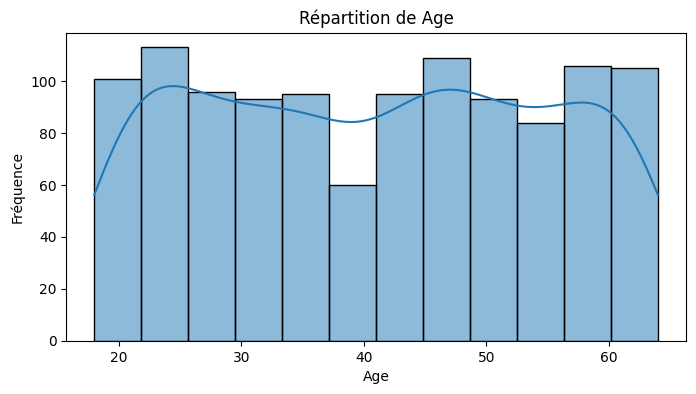

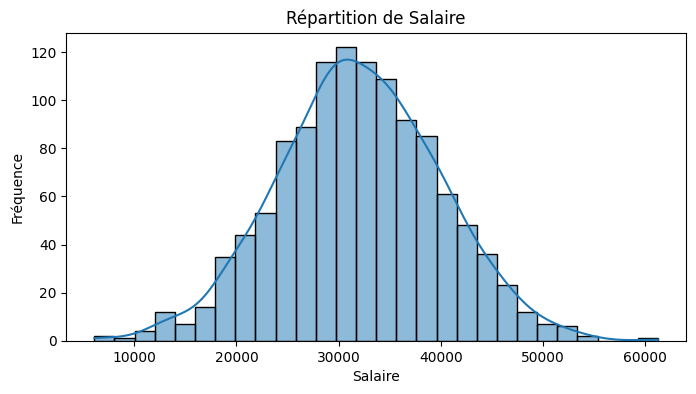

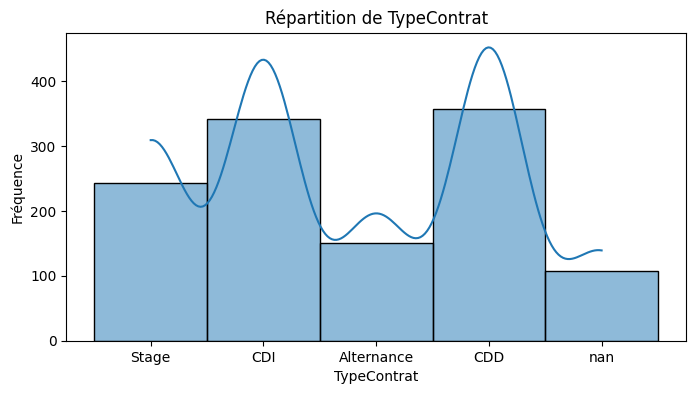

In [82]:
# TODO :
# - Visualiser la répartition des âges, salaires, types de contrat

def visualize_distributions(df, columns=["Age", "Salaire", "TypeContrat"]):
    for col in columns:
        if col in df.columns:
            plt.figure(figsize=(8, 4))
            sns.histplot(df[col].dropna(), kde=True)
            plt.title(f"Répartition de {col}")
            plt.xlabel(col)
            plt.ylabel("Fréquence")
            plt.show()
            
visualize_distributions(df)

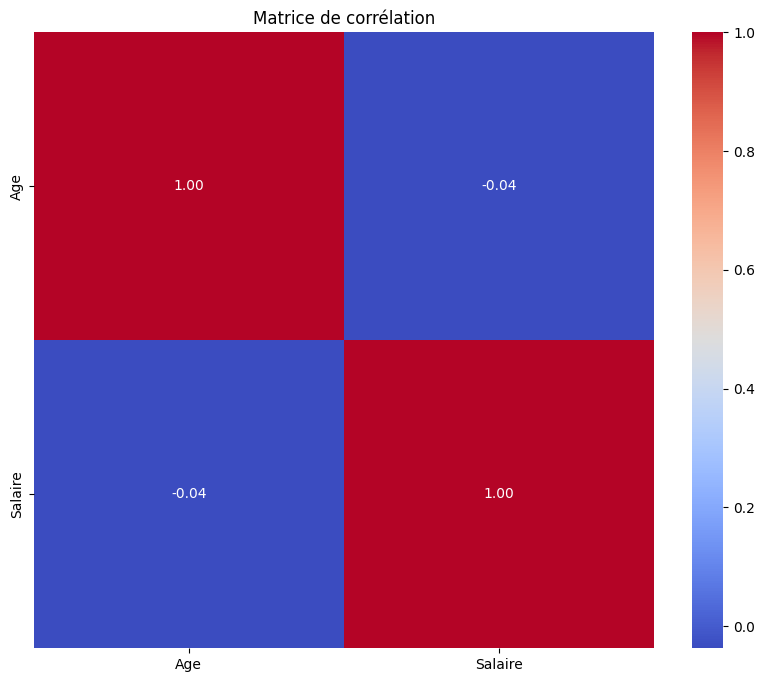

In [83]:
# - Identifier des corrélations ou anomalies intéressantes
def identify_correlations(df):
    numeric_df = df.select_dtypes(include=["int64", "float64"]).drop(
        columns=["EmployeID"], errors="ignore"
    )

    corr = numeric_df.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Matrice de corrélation")
    plt.show()


identify_correlations(df)

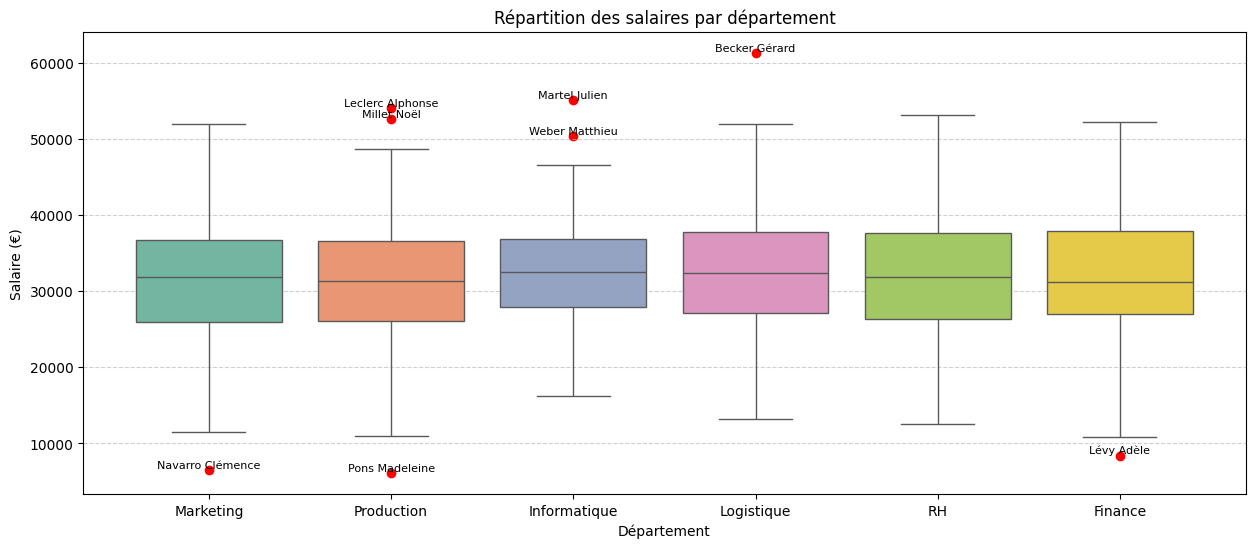

In [84]:
# - Produire des graphiques utiles à l'analyse RH
def plot_rh_analysis(df):
    if "Departement" in df.columns and "Salaire" in df.columns:
        plt.figure(figsize=(15, 6))

        sns.boxplot(
            x="Departement",
            y="Salaire",
            data=df,
            hue="Departement",
            dodge=False,
            palette="Set2",
            showfliers=False,
        )

        for dept in df["Departement"].unique():
            sub_df = df[df["Departement"] == dept]
            q1 = sub_df["Salaire"].quantile(0.25)
            q3 = sub_df["Salaire"].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr

            outliers = sub_df[
                (sub_df["Salaire"] < lower_bound) | (sub_df["Salaire"] > upper_bound)
            ]

            for _, row in outliers.iterrows():
                plt.scatter([dept], [row["Salaire"]], color="red")
                plt.text(
                    dept,
                    row["Salaire"],
                    f'{row["Nom"]} {row["Prenom"]}',
                    fontsize=8,
                    ha="center",
                    va="bottom",
                )

        plt.title("Répartition des salaires par département")
        plt.xlabel("Département")
        plt.ylabel("Salaire (€)")
        plt.grid(axis="y", linestyle="--", alpha=0.6)
        plt.show()

plot_rh_analysis(df)

## Partie 5 – Modélisation (clustering ou **classification**)
Pour la suite du projet vous êtes libres de choisir entre les 2 problèmes:
- Classification : Construire un modèle prédictif du type de contrat et Évaluer la précision sur les nouveaux employés
- Clustering : Identifier naturellement des profils d’employés et Interpréter les groupes pour recommandations RH

In [85]:
# On repart du DataFrame nettoyé avant encodage/normalisation
df = df_before_encoding_and_normalization.copy()
print(df.head())

  EmployeID        Nom      Prenom   Age Sexe   Departement           Poste  \
0  EMP00000     Dijoux    Zacharie  36.0    F     Marketing   Chargé de com   
1  EMP00001   Philippe   Théophile  64.0    H     Marketing   Chargé de com   
2  EMP00002    Blondel   Catherine  53.0    H    Production       Comptable   
3  EMP00003  Berthelot      Maryse  47.0    H     Marketing  Chef de projet   
4  EMP00004    Clément  Christelle  25.0    F  Informatique     Développeur   

    Salaire NiveauEtude TypeContrat DateEmbauche  
0  21649.44       Bac+3       Stage   2017-03-17  
1  22127.03       Bac+3         CDI          NaT  
2  26105.59       Bac+3  Alternance   2023-05-02  
3  29066.15      Master         CDD   2016-03-24  
4  34440.50       Bac+2         CDI   2016-09-04  


In [86]:
# TODO :
# - Appliquer un algorithme de ML (KMeans, LogisticRegression, DecisionTree…)
def apply_ml_algorithm(df):
    print("\n=== Application d'un algorithme de ML (classification TypeContrat) ===")

    # Ajout ancienneté si date disponible
    if "DateEmbauche" in df.columns:
        df = df.copy()
        df["Anciennete"] = (pd.Timestamp.now() - df["DateEmbauche"]).dt.days / 365.25

    df_model = df.dropna(subset=["TypeContrat"]).copy()
    df_model = df_model[df_model["TypeContrat"] != "nan"]  # important

    X = df_model.drop(
        columns=["EmployeID", "DateEmbauche", "TypeContrat"], errors="ignore"
    )
    y = df_model["TypeContrat"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
    categorical_features = X.select_dtypes(
        include=["object", "category"]
    ).columns.tolist()

    numeric_transformer = Pipeline(
        [("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
    )

    categorical_transformer = Pipeline(
        [
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ]
    )

    preprocessor = ColumnTransformer(
        [
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ]
    )

    # GridSearch pour trouver les meilleurs paramètres
    param_grid = {
        "clf__max_depth": [6, 8, 10, None],
        "clf__min_samples_leaf": [1, 2, 4],
        "clf__n_estimators": [200],
        "clf__class_weight": ["balanced"],
    }

    pipe = Pipeline(
        [("prep", preprocessor), ("clf", RandomForestClassifier(random_state=42))]
    )

    grid = GridSearchCV(pipe, param_grid, cv=3, scoring="f1_macro", n_jobs=-1)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    print("best params: ", grid.best_params_)

    y_pred = best_model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"\n Model Accuracy : {acc:.3f}\n")

    print("Entraînement du model terminé.")
    return best_model, df

model_clf, test_data = apply_ml_algorithm(df)


=== Application d'un algorithme de ML (classification TypeContrat) ===
best params:  {'clf__class_weight': 'balanced', 'clf__max_depth': 10, 'clf__min_samples_leaf': 4, 'clf__n_estimators': 200}

 Model Accuracy : 0.224

Entraînement du model terminé.



 Model Accuracy : 0.451

=== Rapport de classification ===
              precision    recall  f1-score   support

  Alternance       0.36      0.59      0.45       151
         CDD       0.47      0.52      0.49       357
         CDI       0.61      0.39      0.47       341
       Stage       0.39      0.55      0.46       243
         nan       0.00      0.00      0.00       108

    accuracy                           0.45      1200
   macro avg       0.37      0.41      0.37      1200
weighted avg       0.44      0.45      0.43      1200



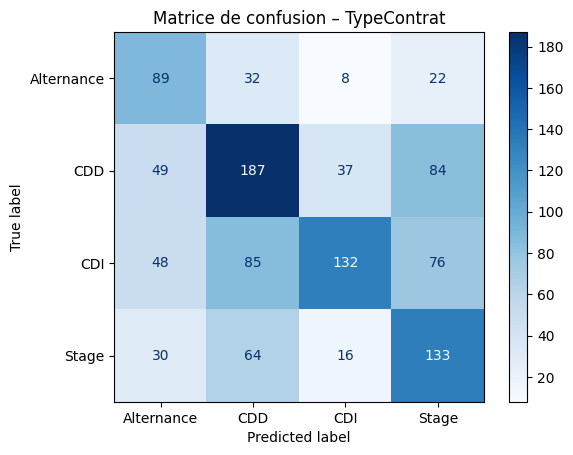

In [87]:
# - Évaluer les résultats obtenus (visualisation ou métriques)
def evaluate_model(best_model, X_test, y_test):
    y_pred = best_model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"\n Model Accuracy : {acc:.3f}\n")

    print("=== Rapport de classification ===")
    print(classification_report(y_test, y_pred, zero_division=0))

    valid_classes = ["Alternance", "CDD", "CDI", "Stage"]
    mask = y_test.isin(valid_classes)
    cm = confusion_matrix(y_test[mask], y_pred[mask], labels=valid_classes)
    disp = ConfusionMatrixDisplay(cm, display_labels=best_model["clf"].classes_)
    disp.plot(cmap=plt.cm.Blues, values_format="d")
    plt.title("Matrice de confusion – TypeContrat")
    plt.show()

evaluate_model(model_clf, test_data.drop(
    columns=["EmployeID", "DateEmbauche", "TypeContrat"], errors="ignore"
), test_data["TypeContrat"])

## Partie 6 – Conclusion et recommandations

In [88]:
# TODO :
# - Synthétiser les problèmes détectés et les corrections apportées
def summarize_issues_and_corrections():
    print("\n=== Synthèse des problèmes que j'ai détecté et des corrections apportées ===\n")

    corrections = [
        "Valeurs manquantes détectées : imputées ou supprimées selon la pertinence",
        "Âges incohérents (moins de 18 ans ou supérieurs à 64 ans) : corrigés via imputation",
        "Salaires anormaux (valeurs nulles, négatives) : remplacés par des valeurs imputées",
        "Dates invalides : nettoyées et converties au format datetime",
        "Doublons dans le dataset : supprimés",
        "Catégories non homogènes (genre, contrat, niveau d’étude) : standardisées",
        "Normalisation des variables numériques pour une échelle comparable",
    ]

    for item in corrections:
        print(" - " + item)


summarize_issues_and_corrections()


=== Synthèse des problèmes que j'ai détecté et des corrections apportées ===

 - Valeurs manquantes détectées : imputées ou supprimées selon la pertinence
 - Âges incohérents (moins de 18 ans ou supérieurs à 64 ans) : corrigés via imputation
 - Salaires anormaux (valeurs nulles, négatives) : remplacés par des valeurs imputées
 - Dates invalides : nettoyées et converties au format datetime
 - Doublons dans le dataset : supprimés
 - Catégories non homogènes (genre, contrat, niveau d’étude) : standardisées
 - Normalisation des variables numériques pour une échelle comparable


In [89]:
# - Présenter une recommandation métier à partir des résultats
def business_recommendations():
    print("\n=== Recommandations métier basées sur l'analyse des données RH ===\n")

    recommendations = [
        "Les performances du model restent limitées -> il est difficile de prédire correctement "
        "le type de contrat des employés uniquement à partir des données disponibles "
        "(âge, sexe, salaire, poste, département...)"
        "\n",
        "Les contrats courts (eg. Stage, Alternance) sont fortement confondus avec les CDD, "
        "ce qui reflète un manque d’informations RH spécifiques permettant de distinguer ces statuts."
        "\n",
        "Pour améliorer la fiabilité de l'analyse prédictive, il est recommandé d'intégrer "
        "de nouvelles variables métier : statut étudiant, durée du contrat, expérience antérieure, "
        "temps plein/partiel, etc..."
        "\n",
        "Le modèle peut être utilisé comme outil d’exploration, mais ne doit pas être engagé "
        "dans une prise de décision opérationnelle en matière de recrutement ou de gestion des talents."
        "\n",
        "Une stratégie Data RH doit être envisagée afin de renforcer la qualité et la pertinence des informations collectées, "
        "favorisant à terme une meilleure anticipation des besoins humains et une optimisation des parcours salariés."
    ]

    for rec in recommendations:
        print(" - " + rec)

business_recommendations()


=== Recommandations métier basées sur l'analyse des données RH ===

 - Les performances du model restent limitées -> il est difficile de prédire correctement le type de contrat des employés uniquement à partir des données disponibles (âge, sexe, salaire, poste, département...)

 - Les contrats courts (eg. Stage, Alternance) sont fortement confondus avec les CDD, ce qui reflète un manque d’informations RH spécifiques permettant de distinguer ces statuts.

 - Pour améliorer la fiabilité de l'analyse prédictive, il est recommandé d'intégrer de nouvelles variables métier : statut étudiant, durée du contrat, expérience antérieure, temps plein/partiel, etc...

 - Le modèle peut être utilisé comme outil d’exploration, mais ne doit pas être engagé dans une prise de décision opérationnelle en matière de recrutement ou de gestion des talents.

 - Une stratégie Data RH doit être envisagée afin de renforcer la qualité et la pertinence des informations collectées, favorisant à terme une meilleure 

### Conclusion du tp
Dans ce projet, j’ai exploré le jeu de données RH et ce du nettoyage jusqu’à la prédiction du type de contrat. J’ai corrigé les erreurs les plus visibles, géré les valeurs manquantes et transformé les informations pour qu’elles soient exploitables par un model de Machine Learning

Le model obtenu n’est pas très performant, surtout pour distinguer les stages et les alternances des CDD/CDI et finalement ça se comprend car les données qu’on avait sous la main ne reflètent pas vraiment ce qui différencie ces types de contrats dans la vraie vie. Il manque des infos clés, comme le statut étudiant ou la durée du contrat.

Ce que je retiens surtout, c’est que l’IA ne fait pas de miracle si la donnée n’est pas la pour l’aider. Mais cette démarche m’a permis de voir tout le chemin entre des données brutes et une analyse qui peut, malgré ses limites, déjà apporter un éclairage RH exploitable